## Transfer Learning

#### Downloading Dataset

In [6]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#     -O ./cats_and_dogs_filtered.zip

In [111]:
import os 
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [11]:
%%matplotlib inline

UsageError: Cell magic `%%matplotlib` not found (But line magic `%matplotlib` exists, did you mean that instead?).


In [13]:
data_set_path = 'cats_and_dogs_filtered.zip'

In [14]:
zipobj = zipfile.ZipFile(data_set_path,mode = 'r')
zipobj.extractall(path = './dataset')

In [71]:
dataset_path = 'dataset/cats_and_dogs_filtered'
train_dataset_path  = os.path.join(dataset_path,'train')
test_dataset_path  = os.path.join(dataset_path,'validation')

### Loading Pre Trained Model
#### Loading mobile net model


In [23]:
IMAGE_SHAPE = (128,128,3)

In [129]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False, weights="imagenet")

##### Freezing Base model

In [31]:
base_model.trainable = False

In [32]:
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [34]:
global_avg_layer = tf.keras.layers.GlobalAvgPool2D()(base_model.output)

In [35]:
global_avg_layer

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d_1')>

In [43]:
prediction_layer = tf.keras.layers.Dense(activation='relu',units = 1,name = 'Prediction_Layer')(global_avg_layer)

### Model

In [103]:
model = tf.keras.Model(inputs= base_model.input, outputs = prediction_layer,name = 'Classification_Model')

In [104]:
model.summary()

Model: "Classification_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [105]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),loss=tf.keras.losses.BinaryCrossentropy(),metrics='accuracy')

### Dataset Pre-processing

In [106]:
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [107]:
train_data = train_datagen.flow_from_directory(train_dataset_path,target_size=(128,128),batch_size=128,class_mode='binary')

Found 2000 images belonging to 2 classes.


In [108]:
valid_data  = valid_datagen.flow_from_directory(test_dataset_path,target_size=(128,128),batch_size=128,class_mode='binary')

Found 1000 images belonging to 2 classes.


### Training A Model

In [109]:
history = model.fit(train_data,epochs=10,callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss'),validation_data=valid_data,batch_size=128)

Epoch 1/10
16/16 [==============================] - 10s 532ms/step - loss: 0.5823 - accuracy: 0.9350 - val_loss: 0.5911 - val_accuracy: 0.9240
Epoch 2/10
16/16 [==============================] - 8s 496ms/step - loss: 0.5585 - accuracy: 0.9400 - val_loss: 0.5881 - val_accuracy: 0.9240
Epoch 3/10
16/16 [==============================] - 8s 535ms/step - loss: 0.5493 - accuracy: 0.9405 - val_loss: 0.5843 - val_accuracy: 0.9270
Epoch 4/10
16/16 [==============================] - 9s 546ms/step - loss: 0.5394 - accuracy: 0.9420 - val_loss: 0.5695 - val_accuracy: 0.9280
Epoch 5/10
16/16 [==============================] - 9s 538ms/step - loss: 0.5353 - accuracy: 0.9450 - val_loss: 0.5647 - val_accuracy: 0.9300
Epoch 6/10
16/16 [==============================] - 9s 570ms/step - loss: 0.5326 - accuracy: 0.9460 - val_loss: 0.5619 - val_accuracy: 0.9300
Epoch 7/10
16/16 [==============================] - 8s 533ms/step - loss: 0.5063 - accuracy: 0.9450 - val_loss: 0.5798 - val_accuracy: 0.9260


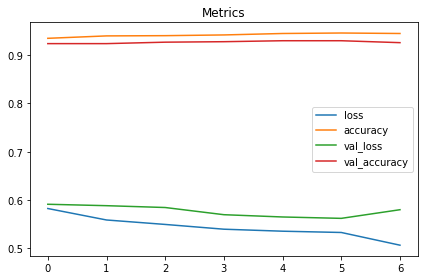

In [116]:
plt.title("Metrics")
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.legend(['loss','accuracy','val_loss','val_accuracy'])
plt.tight_layout()

### Evaluvation

In [118]:
val_loss, val_acc = model.evaluate(valid_data)

8/8 [==============================] - 3s 304ms/step - loss: 0.5798 - accuracy: 0.9260


In [119]:
print("Validation Loss :",val_loss,"\nValidation Accuracy",val_acc)

Validation Loss : 0.5797961950302124 
Validation Accuracy 0.9259999990463257


## Fine Tuning

Fine tuning is training some layers in models with new data which helps model to update its weights while keep other layers as it is.

It alters the base model as we update the model weights.

#### Converting model to trainable

In [122]:
base_model.trainable = True

Defining the layers threshold layer number to keep model from non-training

In [130]:
print("Total Number of Layers in Model :",len(base_model.layers))

Total Number of Layers in Model : 154


In [131]:
threshold_layer = 120

In [132]:
for layers in base_model.layers[:threshold_layer]:
    layers.trainable = False

In [133]:
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),metrics=['accuracy'],loss = tf.keras.losses.BinaryCrossentropy())

#### fine tuning model

In [134]:
history2= model.fit(train_data,epochs=10,batch_size=128,validation_data = valid_data,callbacks=tf.keras.callbacks.EarlyStopping())

Epoch 1/10
16/16 [==============================] - 7s 470ms/step - loss: 0.4402 - accuracy: 0.9480 - val_loss: 0.5652 - val_accuracy: 0.9330
Epoch 2/10
16/16 [==============================] - 8s 472ms/step - loss: 0.4362 - accuracy: 0.9510 - val_loss: 0.5314 - val_accuracy: 0.9310
Epoch 3/10
16/16 [==============================] - 8s 490ms/step - loss: 0.4328 - accuracy: 0.9525 - val_loss: 0.5369 - val_accuracy: 0.9340


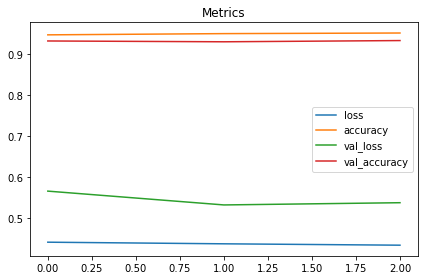

In [135]:
plt.title("Metrics")
plt.plot(history2.history['loss'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_loss'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['loss','accuracy','val_loss','val_accuracy'])
plt.tight_layout()

#### Evaluvation